# [LG AI 해커톤] 시스템 품질 변화로 인한 사용자 불편 예지 및 불만 원인 분석

### Date: 2021-03-15
### Author: Myungsun Kim

## 0. Overview
### 사용된 데이터와 함수의 관계


![img2](img/flow_chart.png)

### 목차
* [1. Error 분석](#1.-Error-분석)
    * 1-1. 에러 타입과 발생 빈도
    * 1-2. Error type별 Error code 분포
    * 1-3. Error type 38 분석
    * 1-4. Error type과 code 전처리
    * 1-5. model별, fwver 평균 에러 발생량 분석
* [2. 필요 함수 정의](#2.-필요-함수-정의)
    * 2-0. 데이터를 유저별, 일별로 분리 (func split_error_data_in_day)
    * 2-1. Error 관련 (func transform_errtype, extract_err)
    * 2-2. Model 관련 (func transform_model_nm, extract_model_nm)
    * 2-3. fwver 관련 (func transform_fwver, extract_fwver)
    * 2-4. quality 관련 (func extract_quality_data)
    * 2-5. 피쳐 통합 (func feature_extraction)
    * 2-6. Error, quality 관계 분석
* [3. 모델 학습](#3.-모델-학습)
    * 3-1. 학습을 위한 함수 정의
    * 3-2. 학습 및 앙상블
* [4. 사용자 불만접수 원인 분석](#4.-사용자-불만접수-원인-분석)
    * 4-1. Error 관련
    * 4-2. Model_nm, fwver 관련
    * 4-3. Quality 관련
* [5. 비즈니스 분석](#5.-비즈니스-분석)
* [6. 결론](#6.-결론)

### 라이브러리 임포트, 변수 정의 및 로드

In [21]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import *
from sklearn.model_selection import KFold
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import matplotlib
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)

# 데이터 경로 설정
data_path = 'data/'

# global 변수 정의
TRAIN_ID_LIST = list(range(10000, 25000))
TEST_ID_LIST = list(range(30000, 45000 - 1))
N_USER_TRAIN = len(TRAIN_ID_LIST)
N_USER_TEST = len(TEST_ID_LIST)
N_ERRTYPE = 42
N_QUALITY = 13

# 데이터 로드
train_qual_df = pd.read_csv(data_path + 'train_quality_data.csv')
train_err_df = pd.read_csv(data_path + 'train_err_data.csv')
test_err_df = pd.read_csv(data_path + 'test_err_data.csv')
test_qual_df = pd.read_csv(data_path + 'test_quality_data.csv')
train_prob_df = pd.read_csv(data_path + 'train_problem_data.csv')

## 1. Error 분석
### 1-1. 에러 타입과 발생 빈도

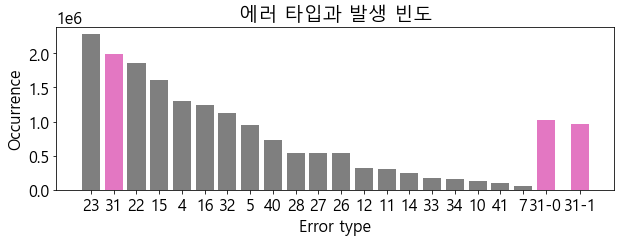

In [7]:
train_err = train_err_df.copy()
err_type = train_err['errtype']
err_code = train_err['errcode'].astype(str)

v, c = np.unique(err_type, return_counts = True)

idx2 = err_type == 31
err_code_sub = err_code.loc[idx2].values
v2, c2 = np.unique(err_code_sub, return_counts=True)

## 에러 타입과 발생 빈도 계산
idx = np.argsort(c)
idx = idx[::-1]
NUM_SHOW = 20
plt.figure(figsize=(10,3))
plt.title('에러 타입과 발생 빈도')
plt.bar(range(NUM_SHOW), list(c[idx[:NUM_SHOW]]), color = 'tab:gray')
plt.bar([1, NUM_SHOW, NUM_SHOW+1.5], [c[idx[:NUM_SHOW]][1]] + list(c2), color = 'tab:pink')
plt.xticks(list(range(NUM_SHOW)) + [NUM_SHOW, NUM_SHOW+1.5], list(v[idx[:NUM_SHOW]]) + ['31-0','31-1'])
plt.xlabel('Error type')
plt.ylabel('Occurrence')
plt.show()

* 총 41개의 error type 중 31번과 같이 error code의 발생 빈도가 대부분의 error type보다 높은 경우가 다수 존재
* error code를 통해 type을 세분화할 필요성이 있다고 판단

### 1-2. Error type별 Error code 분포

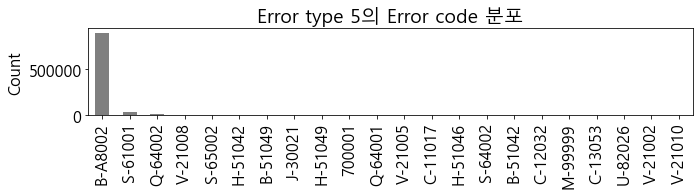

In [8]:
from collections import defaultdict
# 각 error type에 어떤 error code가 있고 각각이 몇개씩인지 err_code_dict에 정리
err_code_dict = defaultdict(dict)
error = 5
# print(f'error type {error}')
idx = err_type == error
err_code_sub = err_code.loc[idx].values
# remove space
# err_code_sub = [s.replace(' ','') for s in err_code_sub]
v, c = np.unique(err_code_sub, return_counts=True)
err_code_dict[error] = dict(zip(v, c))
for i, err_code_sub_c in enumerate(err_code_dict[error]):
    pass
    # print(f'{err_code_sub_c} === {c[i]}')

err_code_df = pd.DataFrame(err_code_dict)

idx = np.argsort(err_code_df[error])[::-1]
reindex_ = err_code_df.index[idx]
err_code_df = err_code_df.reindex(index = reindex_)

plt.figure(1, figsize=(10,3))
err_code_df.iloc[:22].plot(kind='bar',label='columns',ax=plt.gca(), legend = False,
                               color = ['tab:gray'] * 22)
plt.title(f'Error type {error}의 Error code 분포')
plt.ylabel('Count')
plt.tight_layout()
# plt.savefig('errtype_5.png',dpi=100)
plt.show()

* 한가지 code의 비중이 크기 때문에 빈도수가 낮은 error code는 필터링이 필요

### 1-3. Error type 38 분석

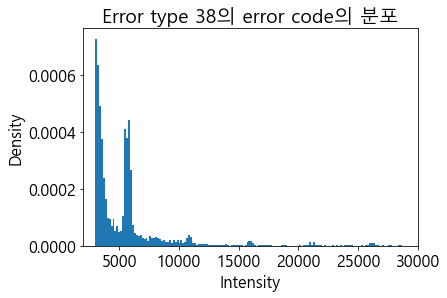

In [9]:
import seaborn as sns

idx_38 = err_type == 38

values = err_code.loc[idx_38].values.astype(int)
values_mean = values.mean()
values_std = values.std()

plt.hist(values, bins=30000, density=True)
plt.xlim(2000, 30000)
plt.xlabel('Intensity')
plt.ylabel('Density')
plt.title('Error type 38의 error code의 분포')
plt.show()

* Error type 38의 code는 값이 매우 다양하게 나타나 numerical 변수로 추정
* Code의 크기가 해당 error의 정도를 나타낼 것이라 예상됨

### 1-4. Error type과 code 전처리

* Error type: 1~42까지 중 29를 제외한 41개가 존재
* Error code: 각 type별로 다양하게 존재
* Error type을 비슷한 유형끼리 묶게 되면 성능이 크게 감소하는데, 반대로 type을 세분화하는 code를 활용하는 것이 유의미할 것이라 판단함
* Error code는 다음과 같은 이유로 그대로 사용할 수 없음
    1. train에는 없지만 test에 있는 error code가 다수 존재
    2. 예시로, Error type 38번에 경우 error code가 5000개 이상 존재해 개별적으로 사용할 경우 복잡도가 지나치게 커짐
* 따라서 빈도수가 높은 Error code만 남겨 type과 조합하고 그 외에는 UNKNOWN으로 처리하여 학습에 제외
* 해당 작업은 process_errcode 함수에서 진행되며 예시로 error type 1에 대한 처리는 다음과 같음
* 0, P로 시작하는 code, 0 이외의 숫자, UNKNOWN의 4가지 유형으로 분류하여 새로운 code 생성함
```python
if e == 1:
    for i, ec in enumerate(errcode):
        if ec == '0':
            new_errcode[np.where(idx)[0][i]] = str(e) + '-' + ec
        elif ec[0] == 'P':
            new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'P'
        elif ec.isdigit():
            new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'num'
        else:
            print(f'Unknown error code for error type {e}')
            new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'UNKNOWN'
```
* 상기 code snippet으로 처리된 error code processing 결과는 아래 표와 같음

|error type|error code|processed errror code|
|------|------|------|
|1|0|1-0|
|1|P-41001|1-P|
|1|P-41010|1-P|
|1|P-41011|1-P|
|1|any digit|1-num|

* train_err_data를 process_errcode 합수에 입력해 새로운 error code 조합을 생성하고 인코더 생성
* test_err_data는 학습 데이터의 인코더를 사용하여 변환함
* UNKNOWN이 포함된 code는 집계하지 않음

In [10]:
from sklearn.preprocessing import LabelEncoder

def process_errcode(errortype, errorcode):
    """
    errortype과 errorcode를 조합해서 새로운 error type을 생성
    ex: error type이 8이고 error code가 3이면 새로운 error code는 8-3으로 변경

    [ Input ]
    errortype: error type에 해당하는 array
    errorcode: 해당 error type의 error code array

    [ Output ]
    new_errcode: error type과 code를 조합하여 생성된 array
    """

    new_errcode = errortype.copy().astype(str)
    for e in range(1, 43):
        idx = errortype == e

        # -------------------------------- 값이 없을 경우 continue
        if idx.sum() == 0:
            continue

        # -------------------------------- 값이 있을 경우에 processing
        errcode = errorcode[idx]

        # 공백 및 문자 전처리
        for i, ec in enumerate(errcode.copy()):
            ec = ec.strip()  # 앞뒤로 공백 제거
            ec = ec.replace('_', '-')
            if '.' in ec:
                ec = ec.split('.')[0]
            if ec.isdigit():
                errcode[i] = str(int(ec))
            errcode[i] = ec

        # error type에 따라 processing
        if e == 1:
            for i, ec in enumerate(errcode):
                if ec == '0':
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + ec
                elif ec[0] == 'P':
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'P'
                elif ec.isdigit():
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'num'
                else:
                    print(f'Unknown error code for error type {e}')
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'UNKNOWN'
        elif e == 5:
            for i, ec in enumerate(errcode):
                if ec[0] in ['Y', 'V', 'U', 'S', 'Q', 'P', 'M', 'J', 'H', 'E', 'D', 'C', 'B']:
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + ec[0]
                elif ec == 'nan':
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'UNKNOWN'
                elif ec.isdigit():
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'num'
                else:
                    print(f'UNKNOWN error code for type {e} :: {ec}')
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'UNKNOWN'
        elif e == 8:
            for i, ec in enumerate(errcode):
                if ec.isdigit():
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'num'
                elif ec in ['PHONE-ERR', 'PUBLIC-ERR']:
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + ec
                else:
                    print(f'UNKNOWN error code for type {e} :: {ec}')
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'UNKNOWN'
        elif e == 9:
            for i, ec in enumerate(errcode):
                if ec.isdigit():
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-num'
                elif ec[0] in ['C', 'V']:
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + ec[0]
                else:
                    print(f'Unknown error code for error type {e}')
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-UNKNOWN'
        elif e == 25:
            for i, ec in enumerate(errcode):
                if 'UNKNOWN' in ec:
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'UNKNOWN'
                elif 'fail' in ec:
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'fail'
                elif 'timeout' in ec:
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'timeout'
                elif 'cancel' in ec:
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'cancel'
                elif 'terminate' in ec:
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'terminate'
                elif ec.isdigit():
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'num'
                else:
                    print(f'Unknown error code for error type {e}')
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'UNKNOWN'
        elif e == 32:
            for i, ec in enumerate(errcode):
                if ec[0] == '-':
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'neg_num'
                else:
                    new_errcode[np.where(idx)[0][i]] = str(e) + '-' + 'pos_num'
        elif e == 38:
            new_errcode[idx] = str(e) + '-num'
        else:
            # 나머지 error type은 개별 error code를 전부 사용
            new_errcode[idx] = np.array([str(e) + '-' + ec for ec in errcode])

    return new_errcode

err_df = train_err_df.loc[:, 'errtype':'errcode'].copy()

# make unique pairs
err_df.drop_duplicates(inplace=True)
err_df = err_df.reset_index(drop=True)

# dataframe을 array로 변경
errortype = err_df['errtype'].values
errorcode = err_df['errcode'].values.astype(str)

# process_errcode 함수를 이용해 새로운 error type을 encoding
new_errcode = process_errcode(errortype, errorcode)
new_errcode_tmp = np.unique(new_errcode)

new_errcode = []
# Unknown 제거
for err in new_errcode_tmp:
    if 'UNKNOWN' not in err:
        new_errcode.append(err)
N_NEW_ERRCODE = len(new_errcode)

# 새로운 error type을 encoding
encoder = LabelEncoder()
encoder.fit(new_errcode)
print('Encoding error code is done')

def get_encoder():
    return encoder

UNKNOWN error code for type 5 :: http
Encoding error code is done


### 1-5. model별, fwver 평균 에러 발생량 분석

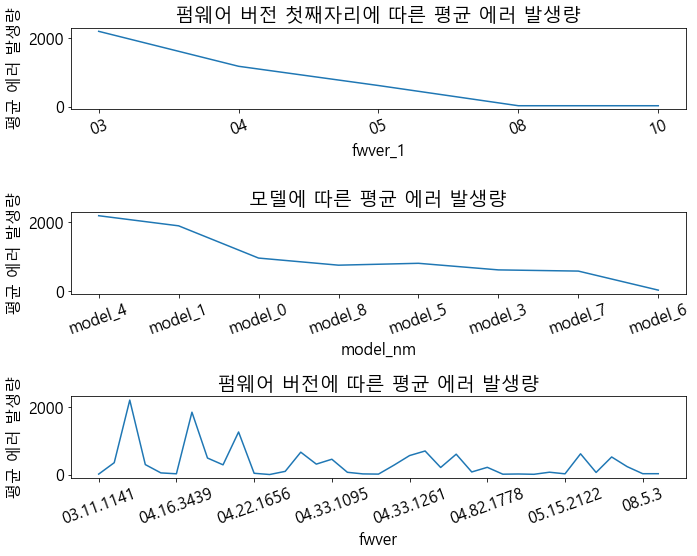

In [11]:
train_err = train_err_df.copy()

# fwver의 8.x.x를 08.x.x로 변경
idx = train_err['fwver'] == '8.5.3'
train_err.loc[idx, 'fwver'] = '08.5.3'

train_err['fwver_1'] = [col[:2] for col in train_err['fwver'].values]

unique_fwver = np.unique(train_err['fwver'].astype(str))
group = train_err.groupby('fwver')

df_fwver = pd.DataFrame(columns = unique_fwver)
for fwver in unique_fwver:
    df_fwver.loc[0, fwver] = len(np.unique(group.get_group(fwver)['user_id']))
    df_fwver.loc[1, fwver] = group.get_group(fwver)['user_id'].shape[0]
df_fwver.index = ['사용자 수','에러 발생량']

unique_model = ['model_'+str(i) for i in [4,1,0,1,8,5,3,7,6]]
group = train_err.groupby('model_nm')

df_model = pd.DataFrame(columns = unique_fwver)
for model in unique_model:
    df_model.loc[0, model] = len(np.unique(group.get_group(model)['user_id']))
    df_model.loc[1, model] = group.get_group(model)['user_id'].shape[0]
df_model.index = ['사용자 수','에러 발생량']

unique_fwver_1 = np.unique(train_err['fwver_1'].astype(str))
group = train_err.groupby('fwver_1')

df_fwver_1 = pd.DataFrame(columns = unique_fwver_1)
for fwver_1 in unique_fwver_1:
    df_fwver_1.loc[0, fwver_1] = len(np.unique(group.get_group(fwver_1)['user_id']))
    df_fwver_1.loc[1, fwver_1] = group.get_group(fwver_1)['user_id'].shape[0]
df_fwver_1.index = ['사용자 수','에러 발생량']

plt.figure(1, figsize=(10,8))
plt.subplot(3,1,1)
df_fwver_1.loc['평균 에러 발생량',:] = df_fwver_1.T['에러 발생량'] / df_fwver_1.T['사용자 수']
df_fwver_1.T['평균 에러 발생량'].plot()
plt.xticks(range(df_fwver_1.shape[1]),df_fwver_1.columns, rotation=20)
plt.ylabel('평균 에러 발생량')
plt.xlabel('fwver_1')
plt.title('펌웨어 버전 첫째자리에 따른 평균 에러 발생량')
# plt.show()

plt.subplot(3,1,2)
df_model.loc['평균 에러 발생량',:] = df_model.T['에러 발생량'] / df_model.T['사용자 수']
df_model.T['평균 에러 발생량'].plot(ax=plt.gca())
plt.xticks(rotation=20)
plt.ylabel('평균 에러 발생량')
plt.xlabel('model_nm')
plt.title('모델에 따른 평균 에러 발생량')


plt.subplot(3,1,3)
df_fwver.loc['평균 에러 발생량',:] = df_fwver.T['에러 발생량'] / df_fwver.T['사용자 수']
df_fwver.T['평균 에러 발생량'].plot()
# df_fwver_col_breif = [c[:4] for c in df_fwver.columns]
plt.xticks(rotation=20)
plt.ylabel('평균 에러 발생량')
plt.xlabel('fwver')
plt.title('펌웨어 버전에 따른 평균 에러 발생량')

plt.tight_layout()
plt.show()

* 버전이 업데이트 되어감에 따라 에러 발생량이 낮아지는 추세 확인

## 2. 필요 함수 정의

### 2-0. 데이터를 유저별, 일별로 분리 (func split_error_data_in_day)
* 확장성 측면에서 30일 전체 데이터가 아닌 일별 분리가 유리함

In [12]:
def split_error_data_in_day(err_df, data_type):
    """
    원본 error_data를 불러와 일별 데이터로 분리

    [Input]
    err_df: train or test error data
    data_type: train or test 지정

    [Output]
    err_df_in_day_user: user id별 일별 error data
    """

    if data_type == 'train':
        user_id_list = TRAIN_ID_LIST
    elif data_type == 'test':
        user_id_list = TEST_ID_LIST

    # 중복 제거
    err_df.drop_duplicates(inplace=True)
    err_df = err_df.reset_index(drop=True)

    # time을 datetime format으로 변경
    err_df['time'] = pd.to_datetime(err_df['time'], format='%Y%m%d%H%M%S')

    # user id 각각에 대해 processing
    err_df_in_day_user = []
    for user_id in tqdm(user_id_list):
        # error data중 user id가 user_id인 데이터
        idx = err_df['user_id'] == user_id
        err_df_sub = err_df.loc[idx, :]

        # key가 day (1~30) 이고 value가 해당 err_df에서 user와 day에 해당하는 부분인 dictionary 정의
        err_in_day = dict()

        # -------------------------------- 해당 user가 error data가 없을 시
        if idx.sum() == 0:
            err_df_in_day_user.append(err_in_day)
            continue

        # -------------------------------- user의 error data가 있을 시 1일부터 31일에 대한 처리
        for day in range(1, 31):
            idx_2 = err_df_sub['time'].dt.day == day
            err_in_day[day] = err_df_sub.loc[idx_2, 'model_nm': 'errcode'].reset_index(drop=True)

        err_df_in_day_user.append(err_in_day)
    del err_df

    return err_df_in_day_user

### 2-1. Error 관련 (func transform_errtype, extract_err)
### Transform data
* 각 user, day마다의 error dataframe을 error array 형태로 변경
* 이 때, error type과 code는 일별 발생 횟수를 집계함
* 예외로 error type 38의 error code는 numeric value라 판단하여 발생 횟수가 아닌 code 숫자의 합계에 대한 피쳐 생성
* error type (42가지) + error code (98가지) + error 38 관련 피쳐 1가지로, (user id 수) x (30) x (141) 형태의 array 반환

### Extract feature from error
* 에러 type과 code를 통해 피쳐를 생성함
* 일별 데이터를 아래 그림과 같이 window마다 summation하여 변환함
    
![img1](img/img1.png)

* window 길이는 사용자 불만 label을 통해 최적화하여 3일로 선정
* 각 error에 대하여 차원 축소를 위해 5가지의 통계적 특징 추출 (mean, max, min, median, standard deviavion)
* extract_err 함수는 (userid 수) x (error type 수 + error code 수 + 1) 의 형태를 가진 dataframe을 반환함

In [13]:
def transform_errtype(user_data):
    """
    일별 error dataframe을 이용하여 error를 array 형태로 변경

    [Input]
    user_data: 한 user에 대해 1일 ~ 31일까지로 분리된 error data dataframe

    [Output]
    err: error code, type, errtype_38_errcode_sum이 합쳐진 파생 array
    """

    err_code = np.zeros((30, N_NEW_ERRCODE))
    err_type = np.zeros((30, N_ERRTYPE))
    errtype_38_errcode_sum = np.zeros((30, 1), dtype=int)

    # 1일~31까지에 대한 처리
    for day in range(1, 31):

        # error가 없는 user를 skip
        if user_data == {}:
            print('Unknown user, skip it')
            break

        # error type과 code를 조합하여 새로운 error code 생성
        transformed_errcode = process_errcode(user_data[day]['errtype'].values,
                                              user_data[day]['errcode'].values.astype(str))

        # 생성된 error code를 encoding
        try:
            transformed_errcode = encoder.transform(transformed_errcode)
        # 새로운 error code가 있는 경우 valid한 값만 남김
        except ValueError or KeyError:
            valid_errcode = []
            for i, errcode in enumerate(transformed_errcode):
                if errcode in new_errcode:
                    valid_errcode.append(errcode)
                else:
                    # errcode에 'UNKNOWN'이 포함되어 있을 시 제외
                    if 'UNKNOWN' not in errcode:
                        print(f'Skip error code {errcode}')

            # valid한 error code만 transform
            transformed_errcode = encoder.transform(valid_errcode)

        # count error code
        v, c = np.unique(transformed_errcode, return_counts=True)
        if v.size == 0:
            continue
        err_code[day - 1][v] += c

        # error type 38만 따로 처리
        idx_38 = user_data[day]['errtype'].values == 38
        errtype_38_errcode_sum[day - 1] = np.sum(user_data[day]['errcode'].values[idx_38].astype(int))

        # cout error type
        errtype = user_data[day][
                      'errtype'].values - 1  # error type이 1~42이므로 index로 바꾸기 위해 1을 빼줌
        v, c = np.unique(errtype, return_counts=True)
        if v.size == 0:
            continue
        err_type[day - 1][v] += c

    # error code, type, 38 관련 피쳐 concatenate
    err = np.concatenate([err_code, err_type, errtype_38_errcode_sum], axis=1)

    return err


def extract_err(err_arr, WINDOW):
    """
    1. error 30일 데이터를 WINDOW마다 summation하고 하루씩 lag
    2. 통계적 피쳐 추출 (min, max, mean, median, standard deviation)

    [Input]
    err_arr: (user id 수) x (day 수 = 30) x (error 수 = N_NEW_ERRCODE + N_ERRTYPE + 1)의 형태를 가진 error array
    WINDOW: window length

    [OUTPUT]
    err_df: features에 해당하는 통계적 특징을 추출한 dataframe
    """

    # 하루씩 lag하며 WINDOW에 해당하는 날의 error count를 summation
    err_list = []
    for i in range(31 - WINDOW):
        sum_ = np.sum(err_arr[:, i:i + WINDOW, :], axis=1)
        err_list.append(sum_)
    err_r = np.concatenate(
        [np.min(err_list, axis=0), np.max(err_list, axis=0), np.mean(err_list, axis=0),
         np.median(err_list, axis=0), np.std(err_list, axis=0)], axis=1)
    err_df = pd.DataFrame(err_r)

    # dataframe의 가독성을 위한 column명 지정
    features = ['min', 'max', 'mean', 'median', 'std']
    data_cols = []
    errcode_name = encoder.inverse_transform(range(N_NEW_ERRCODE))
    for feature in features:
        for i in range(N_NEW_ERRCODE):
            data_cols.append('errorcode_' + errcode_name[i] + '_' + feature)
        for i in range(N_ERRTYPE):
            data_cols.append('errortype_'+ str(i+1) + '_' + feature)
        data_cols.append('errortype_38_code_summation_' + feature)
    err_df.columns = data_cols

    return err_df

### 2-2. Model 관련 (func transform_model_nm, extract_model_nm)
### Transform data 
* 각 user, day마다 error dataframe을 model_nm array 형태로 변경
* 이 때, 요일별로 어떤 model_nm이었는지 저장

### Extract feature from model_nm
* extract_model_nm 함수를 통해 피쳐를 생성하였고 각각에 대한 설명은 다음과 같음

|Feature|Explanation|
|------|------|
|model_exist|0~8 model_nm 사용 유무에 대한 flag|
|model_diff|30일 내에 유저의 model_nm이 변경되었는지에 대한 flag|
|model_upgrade|model_nm 업그레이드 유무에 대한 flag|
|model_downgrade|model_nm 다운그레이드 유무에 대한 flag|
|model_start|유저가 가장 처음에 사용한 model_nm에 대한 범주형 변수|
|model_end|유저가 가장 마지막 사용한 model_nm에 대한 범주형 변수|

* upgrade 및 downgrade는 model 번호가 아닌 fwver을 기준으로 판단하였으며 그에 따른 순서는 아래 표와 같음

|model_nm|fwver|order|
|------|------|------|
|0|04.22.x|3|
|1|04.16.x|2|
|2|04.33.x|4|
|3|05.15.x|7|
|4|03.11.x|1|
|5|04.82.x|6|
|6|10 / 8.5.3|9|
|7|05.66.x|8|
|8|04.73.x|5|

In [14]:
def transform_model_nm(data):
    """
    일별 error dataframe을 이용하여 model_nm을 array형태로 변경

    [Input]
    data: 1일 ~ 31일까지로 분리된 error data dataframe

    [Output]
    model_nm: data에서 model_nm정보만 array형태로 변환
    """

    model_nm = np.zeros((30, 9), dtype=int)
    for day in range(1, 31):
        # 데이터가 없을 시 break
        if data == {}:
            print('Unknown user, skip it')
            break

        # 해당 day에 어떤 model_nm이었는지 저장
        for model in np.unique(data[day]['model_nm']):
            model_nm[day - 1, int(model[-1])] = 1

    return model_nm

def extract_model_nm(model_arr, id_list):
    """
    model array에서 통계적 특징을 추출

    [Input]
    model_arr: (user id 수) x (day 수 = 30) x (model 수 = 9)의 형태를 가진 model array
    id_list: train or test id list

    [OUTPUT]
    model_df: model_nm에서 추출된 특징을 조합한 dataframe
    """

    # train 데이터의 model_nm과 fwver를 기반으로 model의 순서를 정의
    model_sorted_order = np.array([4, 1, 0, 2, 8, 5, 3, 7, 6]) + 1

    # model_diff flag
    model_diff = np.zeros((len(id_list)), dtype=int)

    for i in range(len(id_list)):
        model_diff[i] = (model_arr[i].sum(axis=0) > 0).sum() > 1

    # model_start flag
    model_start = np.zeros((len(id_list)), dtype=int)
    for i in range(len(id_list)):
        occur_idx = np.where(model_arr[i].sum(axis=1))[0]
        if occur_idx.size == 0:
            continue
        first_occur_idx = occur_idx[0]
        model_class = np.where(model_arr[i][first_occur_idx, :])[0][0] + 1  # 없는것과 0을 구분하기 위해 1을 더해준다
        model_start[i] = model_class

    # model_end flag
    model_end = np.zeros((len(id_list)), dtype=int)
    for i in range(len(id_list)):
        occur_idx = np.where(model_arr[i].sum(axis=1))[0]
        if occur_idx.size == 0:
            continue
        last_occur_idx = occur_idx[-1]
        model_class = np.where(model_arr[i][last_occur_idx, :])[0][0] + 1  # 없는것과 0을 구분하기 위해 1을 더해준다
        model_end[i] = model_class

    # model 유무
    model_exist = np.zeros((len(id_list), 9), dtype=int)
    for i in range(len(id_list)):
        model_exist[i, :] = model_arr[i].sum(axis=0) > 0

    # model upgrade
    model_upgrade = np.zeros((len(id_list)), dtype=int)
    model_downgrade = np.zeros((len(id_list)), dtype=int)
    for i in range(len(id_list)):
        if model_start[i] == 0 or model_end[i] == 0:  # unknown user
            continue
        idx1 = np.where(model_start[i] == model_sorted_order)[0][0]
        idx2 = np.where(model_end[i] == model_sorted_order)[0][0]
        if idx1 == idx2:
            pass
        elif idx1 < idx2:
            model_upgrade[i] = 1
        else:
            model_downgrade[i] = -1

    # 처리된 데이터 통합
    model_df = pd.DataFrame(data=model_exist, columns=['model_' + str(i) for i in range(9)])
    model_df['model_diff'] = model_diff
    model_df['model_start'] = pd.Series(model_start, dtype='category')
    model_df['model_end'] = pd.Series(model_end, dtype='category')
    model_df['model_upgrade'] = model_upgrade
    model_df['model_downgrade'] = model_downgrade

    return model_df

### 2-3. fwver 관련 (func transform_fwver, extract_fwver)
### Transform data 
* 각 user, day마다 error dataframe을 fwver array 형태로 변경
* 이 때, 요일별로 어떤 fwver였는지 저장
* fwver이 x. y. z의 형태이므로 이 3가지를 분리하여 저장

### Extract feature from fwver 
* model_nm과 유사한 방식으로 피쳐 생성
* fwver의 x. y. z 중 x만 사용하였으며 나머지 자리는 유의미한 모델 성능 향상을 보이지 않아 제외함

|Feature|Explanation|
|------|------|
|fwver_diff|30일 내에 유저의 fwver이 변경되었는지에 대한 flag|
|fwver_upgrade|fwver 업그레이드 유무에 대한 flag|
|fwver_downgrade|fwver 다운그레이드 유무에 대한 flag|
|fwver_start|유저가 가장 처음에 사용한 fwver에 대한 범주형 변수|
|fwver_end|유저가 가장 마지막 사용한 fwver에 대한 범주형 변수|

In [15]:
def transform_fwver(data):
    """
    일별 error dataframe을 이용하여 fwver array형태로 변경

    [Input]
    data: 1일 ~ 31일까지로 분리된 error data dataframe

    [Output]
    fwver: data에서 fwver정보만 array형태로 변환
    """

    fwver = np.zeros((30, 3), dtype=int)  # 00. 00. 00로 분류
    fwver = fwver.astype(str)

    for day in range(1, 31):
        # 데이터가 없을 시 break
        if data == {}:
            print('Unknown user, skip it')
            break

        # 해당 day에 어떤 model_nm이었는지 저장
        for fwver_u in np.unique(data[day]['fwver']):
            striped_fwver = fwver_u.split('.')
            for i in range(len(striped_fwver)):
                fwver[day - 1, i] = striped_fwver[i]

    return fwver


def extract_fwver(fwver_arr, id_list):
    """
    일별 fwver array에서 통계적 특징을 추출

    [Input]
    fwver_arr: (user id 수) x (day 수 = 30) x (자리 수 = 3)의 형태를 가진 fwver array
    id_list: train or test id list

    [OUTPUT]
    fwver_df: fwver에서 추출된 특징을 조합한 dataframe
    """

    # int type으로 변경
    fwver_arr = fwver_arr.astype(int)

    fwver_diff = np.zeros((len(id_list), 3), dtype=int)
    fwver_start = np.zeros((len(id_list), 3), dtype=int)
    fwver_end = np.zeros((len(id_list), 3), dtype=int)
    fwver_upgrade = np.zeros((len(id_list), 3), dtype=int)
    fwver_downgrade = np.zeros((len(id_list), 3), dtype=int)

    # 각 user마다
    for i in range(len(id_list)):
        for j in range(3):
            data_sub = fwver_arr[i][:, j]
            data_sub = data_sub[data_sub != 0]

            # fwver diff
            fwver_diff[i, j] = np.max([len(np.unique(data_sub)) - 1, 0])
            occur_idx = np.where(data_sub)[0]
            if occur_idx.size == 0:
                continue

            # fwver start
            first_occur_idx = occur_idx[0]
            fwver_class_start = data_sub[first_occur_idx]
            fwver_start[i, j] = fwver_class_start

            # fwver end
            last_occur_idx = occur_idx[-1]
            fwver_class_end = data_sub[last_occur_idx]
            fwver_end[i, j] = fwver_class_end

            # fwver upgrade or downgrade
            fwver_upgrade[i, j] = fwver_class_start < fwver_class_end
            fwver_downgrade[i, j] = (fwver_class_start > fwver_class_end) * -1

    fwver_df = pd.DataFrame()
    for j in range(3):
        fwver_df['fwver_diff_' + str(j)] = fwver_diff[:, j]
        fwver_df['fwver_start_' + str(j)] = pd.Series(fwver_start[:, j])
        fwver_df['fwver_end_' + str(j)] = pd.Series(fwver_end[:, j])
        fwver_df['fwver_upgrade_' + str(j)] = pd.Series(fwver_upgrade[:, j])
        fwver_df['fwver_downgrade_' + str(j)] = pd.Series(fwver_downgrade[:, j])
        break # 가장 앞자리만 사용
    return fwver_df


### 2-4. quality 관련 (func extract_quality_data)

### Filter quality
* quality 데이터는 0~12까지 13개의 quality와 fwver로 이루어져있음
* 다음 표와 같이 quality 데이터 중 중복되거나 의미없는 정보를 삭제
* 13개중 3개를 제외하고 10개의 quality를 사용

|Quality|Explanation|
|------|------|
|quality_0|quality_2와 중복|
|quality_3|값이 0만 존재|
|quality_4|값이 0만 존재|

### Extract feature from quality
* error 데이터와 달리, 별도의 transformation 없이 전체 시점에 대하여 피쳐를 추출
* extract_quality_data 함수를 이용
    1. quality 중 -1의 발생 횟수를 집계
    2. 5가지의 통계적 특징 추출 (mean, max, min, median, standard deviavion)

In [16]:
def extract_quality_data(qual_df, data_type):
    '''
    원본 quality data에서 feature extraction

    [Input]
    data_type: train or test 지정
    qual_df: quality 원본 데이터

    [Output]
    qual_features: quality 데이터의 통계적 특징을 추출한 데이터
    '''

    if data_type == 'train':
        user_id_list = TRAIN_ID_LIST
    else:
        user_id_list = TEST_ID_LIST

    # time을 datetime으로 변경
    qual_df['time'] = pd.to_datetime(qual_df['time'], format='%Y%m%d%H%M%S')

    # 숫자에 포함된 ','를 제거
    qual_df.replace(",", "", regex=True, inplace=True)

    # quality data의 type을 float으로 변경
    qual_df.loc[:, 'quality_0':'quality_12'] = qual_df.loc[:, 'quality_0':'quality_12'].astype(float)

    # drop nan
    drop_idx = np.any(pd.isnull(qual_df), axis=1)
    qual_df = qual_df.loc[~drop_idx, :].reset_index(drop=True)

    # user id별로 그루핑
    group = qual_df.groupby('user_id')
    qual_features = pd.DataFrame(index=user_id_list)
    qual_user_id_list = np.unique(qual_df['user_id'])

    # 각 user id에 대하여 processing
    for user_id in tqdm(qual_user_id_list):
        qual = group.get_group(user_id)
        qual = qual.loc[:, 'quality_0':'quality_12']

        # -1을 count해서 저장
        minus_1_idx = qual == -1
        for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]:
            qual_features.loc[user_id, f'quality_{i}_minus_1_counts'] = minus_1_idx.sum(axis=0).loc[f'quality_{i}']

        # drop minus 1
        minus_1_idx_row = np.any(minus_1_idx, axis=1)
        qual = qual.loc[~minus_1_idx_row, :]

        # feature extraction:: mean, max, median, std
        for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]:
            qual_features.loc[user_id, f'quality_{i}_mean'] = qual.loc[:, f'quality_{i}'].mean(axis=0)
            qual_features.loc[user_id, f'quality_{i}_max'] = qual.loc[:, f'quality_{i}'].max(axis=0)
            qual_features.loc[user_id, f'quality_{i}_med'] = qual.loc[:, f'quality_{i}'].median(axis=0)
            qual_features.loc[user_id, f'quality_{i}_std'] = np.std(qual.loc[:, f'quality_{i}'], axis=0)

    # nan을 0으로 변경
    qual_features = qual_features.reset_index(drop=True)
    qual_features = qual_features.fillna(0)

    return qual_features


### 2-5. 피쳐 통합 (func feature_extraction)
* 앞서 생성된 피쳐를 통합하였으며 다음 순서로 진행됨
    1. Extract error type, code
    2. Extract model_nm
    3. Extract fwver
    4. Extract quality 
    5. Concatenate all the dataframes

In [17]:
def feature_extraction(data_type, err_df, qual_df):
    """
    데이터 통합 함수이며, 다음 순서로 피쳐를 추출
    1. Extract error type, code
    2. Extract model_nm
    3. Extract fwver
    4. Extract quality
    5. Concatenate

    [Input]
    data_type: train or test
    err_df: raw error data
    qual_df: raw quality data

    [Output]
    transformed_data: error, model, fwver, quality에서 추출된 피쳐를 합친 데이터
    """
    if data_type == 'train':
        n_user = N_USER_TRAIN
        id_list = TRAIN_ID_LIST
    elif data_type == 'test':
        n_user = N_USER_TEST
        id_list = TEST_ID_LIST

    # -------------------------------- error 데이터 처리
    # raw error 데이터를 일별, 유저별로 분리
    print('Splitting error data in day...')
    err_df_in_day_user = split_error_data_in_day(err_df, data_type)
    data_list = []
    for user_idx in range(n_user):
        data_list.append(err_df_in_day_user[user_idx])
    print('Splitting error data in day is done')

    ### 1. extract features from error
    print('Extract features from error...')
    err_list = []
    for data in tqdm(data_list):
        err_list.append(transform_errtype(data))
    err_arr = np.array(err_list)
    err_df = extract_err(err_arr, WINDOW=3)
    print('Extract features from error is done')

    ### 2. extract features from model_nm
    print('Extract features from model...')
    model_list = []
    for data in tqdm(data_list):
        model_list.append(transform_model_nm(data))
    model_arr = np.array(model_list)
    model_df = extract_model_nm(model_arr, id_list)
    print('Extract features from model is done')

    ### 3. extract features from fwver
    print('Extract features from fwver...')
    fwver_list = []
    for data in tqdm(data_list):
        fwver_list.append(transform_fwver(data))
    fwver_arr = np.array(fwver_list)
    fwver_df = extract_fwver(fwver_arr, id_list)
    print('Extract features from fwver is done')

    # -------------------------------- quality 데이터 처리
    ### 4. quality data transformation and feature extraction
    print('Extract features from quality...')
    quality_df = extract_quality_data(qual_df, data_type)
    print('Extract features from quality is done')

    # -------------------------------- Concatenate features
    ### 5. Concatenate all the features
    transformed_data = pd.concat([err_df, model_df, fwver_df, quality_df], axis=1)

    return transformed_data

### 2-6. Error, quality 관계 분석

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 12434/15000 [04:07<00:45, 55.92it/s]

UNKNOWN error code for type 5 :: http


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8281/8281 [01:07<00:00, 122.80it/s]


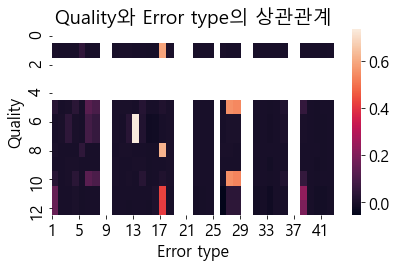

In [18]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

train_err = train_err_df.copy()
train_err['time'] = pd.to_datetime(train_err['time'], format='%Y%m%d%H%M%S')

# error code encoder load
encoder = get_encoder()
errcode_names = encoder.classes_

# 유저별로 processing하고 concatenate
err_df_in_day_user = split_error_data_in_day(train_err, 'train')
data_list = []
for user_idx in range(15000):
    data_list.append(err_df_in_day_user[user_idx])

err_list = []
for data in tqdm(data_list):
    err_list.append(transform_errtype(data))
train_err_arr = np.array(err_list)
train_err_arr = train_err_arr[:,:,-N_ERRTYPE-1:-1]

train_quality = train_qual_df.copy()
train_quality.replace(",", "", regex=True, inplace=True)

drop_idx = np.any(train_quality == -1, axis=1)
train_quality = train_quality.loc[~drop_idx,:].reset_index(drop=True)

train_quality['time'] = pd.to_datetime(train_quality['time'], format='%Y%m%d%H%M%S')

invalid_idx = train_quality['time'].dt.month != 11
train_quality = train_quality.loc[~invalid_idx,:].reset_index(drop=True)

train_user_id = list(range(10000, 25000))
train_quality_arr = np.zeros((len(train_user_id), 13, 30))

for user_id in tqdm(np.unique(train_quality['user_id'])):
    idx = train_quality['user_id'] == user_id
    days = train_quality.loc[idx,'time'].dt.day
    if idx.sum() == 0:
        continue
    for day in np.unique(days):
        idx2 = days == day
        val = train_quality.loc[idx.values, 'quality_0':'quality_12'].iloc[idx2.values].astype(float)
        if val.shape[0] != 0:    
            train_quality_arr[user_id-10000, :, day-1] = np.nanmean(val, axis=0)

results = np.zeros((13, 42))
for i in range(13):
    for j in range(42):
        results[i,j] = np.corrcoef(np.median(train_quality_arr[:,i,:],axis=1), np.median(train_err_arr, axis=1)[:,j])[0,1]

import seaborn as sns
plt.figure()
sns.heatmap(results)
plt.xticks(range(42)[::4], range(1, 43)[::4])
plt.ylabel('Quality')
plt.xlabel('Error type')
plt.title('Quality와 Error type의 상관관계')
plt.tight_layout()
plt.show()

* 특정 quality 값과 error 발생량의 높은 상관 관계 존재
* error type별로 주관하는 quality 측정 지표가 존재할 것으로 추정

## 3. 모델 학습

In [23]:
# X 데이터 생성
print('Feature extraction from train data start')
train_X = feature_extraction('train', train_err_df, train_qual_df)
print('Feature extraction from train data end')

In [24]:
# y 데이터 생성
train_prob = train_prob_df.copy()
train_y = np.zeros((N_USER_TRAIN))
train_y[train_prob.user_id.unique() - 10000] = 1
print('Make train, test and label data is done')

Make train, test and label data is done


### 3-1. 학습을 위한 함수 정의

* lgb_train_model 함수를 이용해 lightgbm 모델 학습 및 추론
* cat_train_model 함수를 이용해 catboost 모델 학습 및 추론
* Bayesian optimization을 통해 파라미터를 튜닝하였으며 제출 코드에는 포함하지 않음


In [25]:
def f_pr_auc(probas_pred, y_true):
    """
    lightgbm custom loss functions

    [Input]
    probas_pred: 예측 결과
    y_true: 실제값

    [Output]
    metric 이름, auc 값, whether maximize or minimize (True is maximize)
    """

    labels = y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score = auc(r, p)
    return "pr_auc", score, True


def lgb_train_model(train_x, train_y, params, n_fold, fold_rs=0, categorical_feature = ['model_start','model_end']):
    """
    lightgbm cross validation with given data

    [Input]
    train_x, train_y: 학습에 사용될 data와 label
    params: lightgbm parameter
    n_fold: k-fold cross validation의 fold 수
    fold_rs: fold를 나눌 random state

    [Output]
    models: fold별로 피팅된 model
    valid_probs: validation set에 대한 예측 결과
    """

    valid_probs = np.zeros((train_y.shape))

    # -------------------------------------------------------------------------------------
    # Kfold cross validation

    models = []
    k_fold = KFold(n_splits=n_fold, shuffle=True, random_state=fold_rs)
    # split train, validation set
    for train_idx, val_idx in k_fold.split(train_x):

        # input 데이터 형식이 dataframe일 때와 array일 때를 구분
        if type(train_x) == pd.DataFrame:
            X = train_x.iloc[train_idx, :]
            valid_x = train_x.iloc[val_idx, :]
        elif type(train_x) == np.ndarray:
            X = train_x[train_idx, :]
            valid_x = train_x[val_idx, :]
        else:
            print('Unknown data type for X')
            return -1, -1

        y = train_y[train_idx]
        valid_y = train_y[val_idx]

        d_train = lgb.Dataset(X, y, categorical_feature=categorical_feature)
        d_val = lgb.Dataset(valid_x, valid_y, categorical_feature=categorical_feature)

        # run training
        model = lgb.train(
            params,
            train_set=d_train,
            num_boost_round=1000,
            valid_sets=d_val,
            feval=f_pr_auc,
            early_stopping_rounds=100,
            verbose_eval=False,
        )

        # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_probs[val_idx] = valid_prob

        models.append(model)

    return models, valid_probs


def cat_train_model(train_x, train_y, params, n_fold, fold_rs=0):
    """
    catboost cross validation with given data

    [Input]
    train_x, train_y: 학습에 사용될 data와 label
    params: catboost parameter
    n_fold: k-fold cross validation의 fold 수
    fold_rs: fold를 나눌 random state

    [Output]
    models: fold별로 피팅된 model
    valid_probs: validation set에 대한 예측 결과
    """

    valid_probs = np.zeros((train_y.shape))
    models = []
    # -------------------------------------------------------------------------------------
    # Kfold cross validation
    k_fold = KFold(n_splits=n_fold, shuffle=True, random_state=fold_rs)
    for train_idx, val_idx in k_fold.split(train_x):
        # split train, validation set
        if type(train_x) == pd.DataFrame:
            X = train_x.iloc[train_idx, :]
            valid_x = train_x.iloc[val_idx, :]
        elif type(train_x) == np.ndarray:
            X = train_x[train_idx, :]
            valid_x = train_x[val_idx, :]
        else:
            print('Unknown data type for X')
            # return -1, -1
        y = train_y[train_idx]
        valid_y = train_y[val_idx]

        train_dataset = Pool(data=X,
                             label=y,
                             cat_features=['model_start', 'model_end'])

        valid_dataset = Pool(data=valid_x,
                             label=valid_y,
                             cat_features=['model_start', 'model_end'])

        cbm_clf = CatBoostClassifier(**params)

        cbm_clf.fit(train_dataset,
                    eval_set=valid_dataset,
                    verbose=False,
                    plot=False,
                    )

        # cal valid prediction
        valid_prob = cbm_clf.predict_proba(valid_x)
        valid_probs[val_idx] = valid_prob[:, 1]

        models.append(cbm_clf)

    return models, valid_probs

### 3-2. 학습 및 앙상블

In [ ]:
lgb_param = {
    'force_col_wise': True,
    'objective': 'binary',
    'tree_learner': 'data',
    'boosting': 'gbdt',
    'metrics': 'auc',
    'colsample_bynode': 0.3898135486693247,
    'colsample_bytree': 0.18842555877544384,
    'learning_rate': 0.017650166362369914,
    'min_sum_hessian_in_leaf': 0.06737426241310715,
    'reg_alpha': 0.8971653884407311,
    'reg_lambda': 0.11885254289919682,
    'subsample': 0.960014724793571,
    'random_state': 0,
    'verbose': -1,
    'max_depth': -1,
    'bagging_freq': 19,
    'min_data_in_leaf': 25,
    'max_bin': 5,
    'n_jobs': 6,
    'num_leaves': 40,
}

cat_param = {
    'custom_loss': 'AUC',
    'bagging_temperature': 0.0002815749995043748,
    'learning_rate': 0.07949149044006878,
    'random_strength': 1326.5863036592555,
    'scale_pos_weight': 0.563214416647416,
    'subsample': 0.6014021044879473,
    'colsample_bylevel': 0.46663684733988225,
    'border_count': 59,
    'depth': 7,
    'iterations': 816,
    'l2_leaf_reg': 47,
    'thread_count': 6
}

models_lgb, valid_probs_lgb = lgb_train_model(train_X, train_y, lgb_param, n_fold = 10, fold_rs=0)
auc_score_lgb = roc_auc_score(train_y, valid_probs_lgb)
print('Lightgbm validation score:: {:.5f}'.format(auc_score_lgb))

print('Catboost model fitting...')
models_cat, valid_probs_cat = cat_train_model(train_X, train_y, cat_param, n_fold = 10, fold_rs=0)
auc_score_cat = roc_auc_score(train_y, valid_probs_cat)
print('Catboost validation score:: {:.5f}'.format(auc_score_cat))

# lightgbm 모델과 catboost 모델을 앙상블
weight = [0.6, 0.4] # 앙상블 weight 지정
auc_score_ens = roc_auc_score(train_y, valid_probs_lgb * weight[0] + valid_probs_cat * weight[1])
print('Ensemble validation score:: {:.5f}'.format(np.max(auc_score_ens)))

# 결과 plot
import matplotlib.pyplot as plt
import matplotlib
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)
plt.rcParams['axes.unicode_minus'] = False

plt.bar(range(3), [auc_score_lgb, auc_score_cat, auc_score_ens], color = 'tab:gray')
plt.bar([2], [auc_score_ens], color = 'tab:pink')
plt.xticks(range(3),['LGB','CAT','ENS'])
plt.title('10-fold cv 성능 비교')
plt.ylim([0.84, 0.846])
plt.ylabel('AUC')
plt.show()

## 4. 사용자 불만접수 원인 분석
분석 결과 사용자 불만접수 원인을 크게 9가지 유형으로 분류

* 높은 빈도의 error 발생
* 특정 error type 발생
* 특정 error code 발생
* Error type 38 내 높은 error code 발생
* 특정 model_nm, fwver 의 소유
* Model_nm, fwver의 업그레이드/다운그레이드/변경
* -1 값 발생
* Quality의 높은 수치
* 2시간 이내에 quality 변화

### 4-1. Error 관련
#### 불만 제기 여부에 따른 하루 평균 에러 발생량

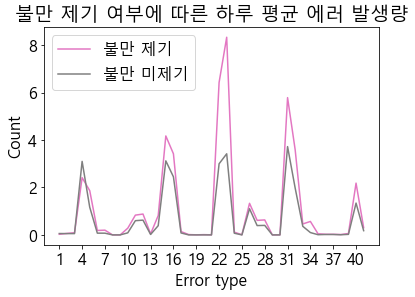

In [27]:
train_prob = train_prob_df.copy()

train_prob['time'] = pd.to_datetime(train_prob['time'], format='%Y%m%d%H%M%S')
train_prob['time_day'] = train_prob['time'].dt.day
train_prob['time_hour'] = train_prob['time'].dt.hour
# del train_prob['time']

# 일별로 변경
problem_arr = np.zeros((15000, 30), dtype=int)
for i in range(train_prob.shape[0]):
    user_id = train_prob.loc[i,'user_id']
    time_day = train_prob.loc[i, 'time_day']
    problem_arr[user_id - 10000, time_day-1] += 1

# 에러 타입의 전체 합계
err_arr_sub = train_err_arr[:,:,-N_ERRTYPE-1:-1]

# 문제가 발생한 유저와 발생하지 않은 유저로 분리
problem_user = (problem_arr.sum(axis=1) > 0)
problem_0_err = err_arr_sub[problem_user,:,:]
problem_1_err = err_arr_sub[~problem_user,:,:]

# 유저당 일별 평균값 산출
problem_0_err = problem_0_err.mean(axis=0).mean(axis=0)
problem_1_err = problem_1_err.mean(axis=0).mean(axis=0)

plt.figure(figsize=(6,4))
plt.plot(problem_0_err, label='불만 제기', color='tab:pink')
plt.plot(problem_1_err, label='불만 미제기', color='tab:gray')
plt.xlabel('Error type')
plt.ylabel('Count')
plt.title('불만 제기 여부에 따른 하루 평균 에러 발생량')
plt.xticks(range(42)[::3], range(1,43)[::3])
plt.legend()
plt.show()

* 불만을 제기한 사용자의 경우 에러가 많이 발생함

#### 에러 발생량과 사용자 불만 여부의 상관관계

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 12438/15000 [03:22<00:37, 67.97it/s]

UNKNOWN error code for type 5 :: http


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:05<00:00, 61.13it/s]


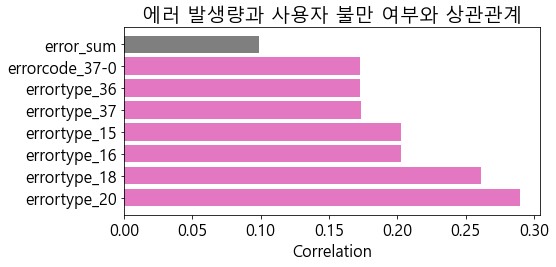

In [28]:
# 유저별로 processing하고 concatenate
err_list = []
for data in tqdm(data_list):
    err_list.append(transform_errtype(data))
err_arr = np.array(err_list)
err_df = extract_err(err_arr, WINDOW=1)

# 각각이 어떤 feature인지
data_cols = []
for i in range(N_NEW_ERRCODE):
    data_cols.append('errorcode_' + errcode_names[i])
for i in range(N_ERRTYPE):
    data_cols.append('errortype_'+ str(i+1))
data_cols.append('errortype_38_code_summation')

# 제외하고 분석할 error code 제외
drop_codes = ['errorcode_'+ str(c) + '-' for c in [10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 35, 36, 41]]

remaining_idx = []
for i in range(err_arr.shape[2]):
    flag = True
    for drop_code in drop_codes:
        if drop_code in data_cols[i]:
            flag = False
            break
    if flag:
        remaining_idx.append(i)

err_arr = err_arr[:,:,remaining_idx]
data_cols = np.array(data_cols)[remaining_idx]

N_FEATURES = len(data_cols)

feature = []
for i in range(err_df.shape[1]):
    remain = True
    col = err_df.columns[i]
    for code in drop_codes:
        if code in col:
            remain = False
            break
    if remain:
        feature.append(err_df[col])
feature = pd.concat(feature, axis=1)

corr_result = []
# 전체 error code와 type 개별적으로
for err_idx in range(N_FEATURES):
    err_arr_sub = err_arr[:,:,err_idx]
    corr_result.append(np.corrcoef(problem_arr.sum(axis=1), err_arr_sub.sum(axis=1))[0,1])
corr_result = np.array(corr_result)

# nan 제거
nan_idx = np.isnan(corr_result)
corr_result = corr_result[~nan_idx]
columns = np.array(data_cols)
columns = columns[~nan_idx]

# 높은 순서대로 sorting
idx = np.argsort(corr_result)[::-1]
corr_result = corr_result[idx]
columns = columns[idx]

NUM_SHOW = 7
corr_result = corr_result[:NUM_SHOW]
columns = columns[:NUM_SHOW]

# plot
plt.figure(figsize=(8,4))
plt.barh(range(NUM_SHOW), corr_result, color='tab:pink')

# 전체 error type의 sum
err_arr_sub = err_arr[:,:,-N_ERRTYPE-1:-1]
sum_corr = np.corrcoef(problem_arr.sum(axis=1), err_arr_sub.sum(axis=2).sum(axis=1))[0,1]

plt.barh([NUM_SHOW], [sum_corr], color='tab:gray')
plt.yticks(range(NUM_SHOW+1), np.append(columns, 'error_sum'))
plt.xlabel('Correlation')
plt.title('에러 발생량과 사용자 불만 여부와 상관관계')
plt.tight_layout()
plt.show()

* 모든 error의 총 발생보다 type이나 code를 개별적으로 보는 것이 상관성이 높게 나타남

#### 에러의 산발성에 따른 사용자 불만 분석

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [04:16<00:00,  8.86s/it]


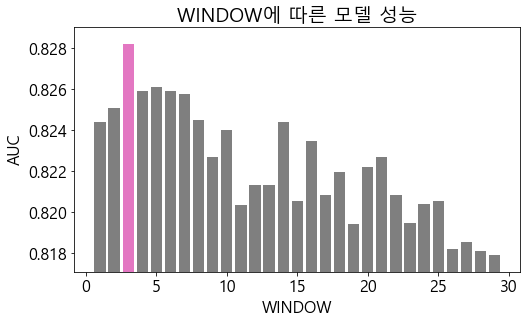

In [29]:
# problem user
problem_user = (problem_arr.sum(axis=1) > 0)

# 사용할 기본 파라미터 정의
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'seed': 1015,
    'verbose': 0,
    'n_jobs':-1,
    'force_col_wise':True
}

# WINDOW를 1~30으로 바꿔가며 모델 성능 비교
result = []
for WINDOW in tqdm(range(1, 30)):
    err_list = []
    for i in range(31 - WINDOW):
        sum_ = np.sum(err_arr[:, i:i + WINDOW, :], axis=1)
        err_list.append(sum_)
    err_r = np.concatenate(
        [np.min(err_list, axis=0), np.max(err_list, axis=0), np.mean(err_list, axis=0),
         np.median(err_list, axis=0), np.std(err_list, axis=0)], axis=1)
    
    _, valid_probs = lgb_train_model(err_r, problem_user, params, 5, categorical_feature = None)
    auc_score = roc_auc_score(problem_user, valid_probs)
    
    result.append(auc_score)

plt.figure(figsize=(8,4.5))
plt.bar(range(1, 1+len(result)), result, color='tab:gray')
plt.bar([3], result[2], color='tab:pink')
# plt.xticks(range(len(result)), range(1, 1+len(result)))
plt.ylim((np.min(result)* 0.999, np.max(result) * 1.001))
plt.xlabel('WINDOW')
plt.ylabel('AUC')
plt.title('WINDOW에 따른 모델 성능')
plt.show()

* 한 달 동안 발생한 error의 총 합보다 3일의 window마다의 합계가 관련성이 큼
* 산발적 error 발생 대비 error 발생의 집약도가 클 수록 영향력을 보이는 것으로 추정됨

#### 불만 여부에 따른 에러 38 평균값 분석

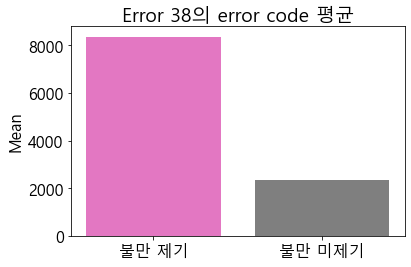

In [30]:
err_38 = err_arr[:,:,-1]
err_38_mean_1 = err_38.sum(axis=1)[problem_user].mean()
err_38_mean_2 = err_38.sum(axis=1)[~problem_user].mean()

plt.bar(range(2), [err_38_mean_1, err_38_mean_2],  color='tab:gray')
plt.bar([0], [err_38_mean_1],  color='tab:pink')
plt.ylim(0,8800)
plt.ylabel('Mean')
plt.title('Error 38의 error code 평균')
plt.xticks(range(2), ['불만 제기','불만 미제기'])
plt.tight_layout()
plt.show()

* 불만을 제기한 사용자의 error type 38의 code 평균이 제기하지 않은 사용자에 비해 상당히 큼

#### 에러 38 합계의 영향 분석

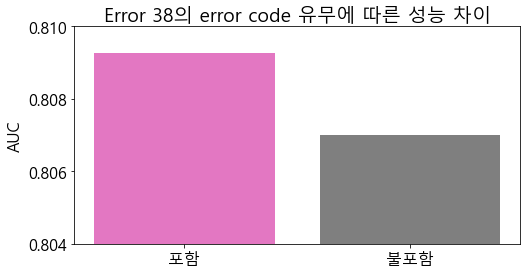

In [31]:
err_arr_sub_1 = err_arr[:,:,-N_ERRTYPE-1:] # 포함
err_arr_sub_2 = err_arr[:,:,-N_ERRTYPE-1:-1] # 불포함

result_38 = []
for data in [err_arr_sub_1, err_arr_sub_2]:
    err_list = []
    for i in range(31 - WINDOW):
        sum_ = np.sum(data[:, i:i + WINDOW, :], axis=1)
        err_list.append(sum_)
    err_r = np.concatenate(
        [np.min(err_list, axis=0), np.max(err_list, axis=0), np.mean(err_list, axis=0),
         np.median(err_list, axis=0), np.std(err_list, axis=0)], axis=1)
    
    _, valid_probs = lgb_train_model(err_r, problem_user, params, 5, categorical_feature = None)
    auc_score = roc_auc_score(problem_user, valid_probs)
    result_38.append(auc_score)

plt.figure(figsize=(8,4))
plt.bar([0], result_38[0], color='tab:pink')
plt.bar([1], result_38[1], color='tab:gray')
plt.xticks(range(2),['포함','불포함'])
plt.ylabel('AUC')
plt.title('Error 38의 error code 유무에 따른 성능 차이')
plt.ylim(0.804, 0.81)
plt.show()

* Error 38의 error code 유무에 따른 성능 차이가 존재

### 4-2. Model_nm, fwver 관련
#### 모델별 불만 발생량

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:24<00:00, 617.44it/s]


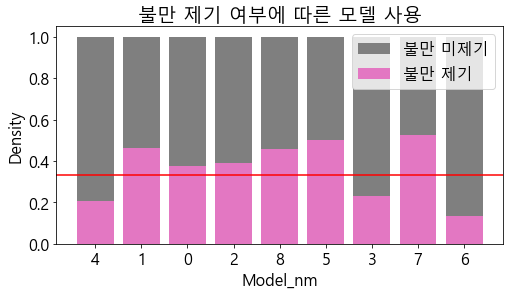

In [32]:
# model 관련 피쳐 생성
model_list = []
for data in tqdm(data_list):
    model_list.append(transform_model_nm(data))
model_arr = np.array(model_list)
model_df = extract_model_nm(model_arr, range(10000,25000))

density = []
for i in range(9):
    model_idx = (model_df['model_'+str(i)] == 1).values
    problem_user_model = problem_user[model_idx]
    density.append(problem_user_model.mean())
density = np.array(density)

plt.figure(figsize=(8,4))
model_sort_order =  np.array([4, 1, 0, 2, 8, 5, 3, 7, 6])
plt.bar(range(9), [1] * 9, color='tab:gray', label='불만 미제기')
plt.axhline(y=1/3, color='r', linestyle='-')
plt.bar(range(9), density[model_sort_order], color='tab:pink', label='불만 제기')
plt.xticks(range(9), model_sort_order)
plt.xlabel('Model_nm')
plt.ylabel('Density')
plt.legend()
plt.title('불만 제기 여부에 따른 모델 사용')
plt.show()

* 뚜렷한 경향은 보이지 않으나 모델 별로 불만 제기 비율이 높거나 낮은 모델이 존재

#### 펌웨어별 불만 발생

  0%|▋                                                                                                                                                                                           | 51/15000 [00:00<00:29, 509.80it/s]

Extract features from fwver...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:25<00:00, 577.11it/s]


Extract features from fwver is done


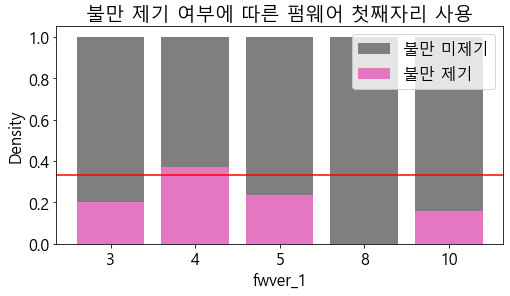

In [33]:
print('Extract features from fwver...')
fwver_list = []
for data in tqdm(data_list):
    fwver_list.append(transform_fwver(data))
fwver_arr = np.array(fwver_list)
id_list = range(10000, 25000)
fwver_arr = fwver_arr.astype(int)
fwver_diff = np.zeros((len(id_list), 3), dtype=int)
fwver_start = np.zeros((len(id_list), 3), dtype=int)
fwver_end = np.zeros((len(id_list), 3), dtype=int)
fwver_upgrade = np.zeros((len(id_list), 3), dtype=int)
fwver_downgrade = np.zeros((len(id_list), 3), dtype=int)

# 각 user마다
for i in range(len(id_list)):
    for j in range(3):
        data_sub = fwver_arr[i][:, j]
        data_sub = data_sub[data_sub != 0]

        # fwver diff
        fwver_diff[i, j] = np.max([len(np.unique(data_sub)) - 1, 0])
        occur_idx = np.where(data_sub)[0]
        if occur_idx.size == 0:
            continue

        # fwver start
        first_occur_idx = occur_idx[0]
        fwver_class_start = data_sub[first_occur_idx]
        fwver_start[i, j] = fwver_class_start

        # fwver end
        last_occur_idx = occur_idx[-1]
        fwver_class_end = data_sub[last_occur_idx]
        fwver_end[i, j] = fwver_class_end

        # fwver upgrade or downgrade
        fwver_upgrade[i, j] = fwver_class_start < fwver_class_end
        fwver_downgrade[i, j] = (fwver_class_start > fwver_class_end) * -1

fwver_df = pd.DataFrame()
for j in range(3):
    fwver_df['fwver_diff_' + str(j)] = fwver_diff[:, j]
    fwver_df['fwver_start_' + str(j)] = pd.Series(fwver_start[:, j])
    fwver_df['fwver_end_' + str(j)] = pd.Series(fwver_end[:, j])
    fwver_df['fwver_upgrade_' + str(j)] = pd.Series(fwver_upgrade[:, j])
    fwver_df['fwver_downgrade_' + str(j)] = pd.Series(fwver_downgrade[:, j])
fwver_df['fwver_start'] = fwver_df['fwver_start_0'].astype(str)+'.' + fwver_df['fwver_start_1'].astype(str)+'.' + fwver_df['fwver_start_2'].astype(str)
fwver_df['fwver_end'] = fwver_df['fwver_end_0'].astype(str)+'.' + fwver_df['fwver_end_1'].astype(str)+'.' + fwver_df['fwver_end_2'].astype(str)

print('Extract features from fwver is done')

unique_fwver_1 = np.unique(fwver_df['fwver_start_0'])
density = []
for fwver in unique_fwver_1:
    fwver_idx = (fwver_df['fwver_start_0'] == fwver).values
    problem_user_fwver = problem_user[fwver_idx]
    density.append(problem_user_fwver.mean())
density = np.array(density)

N_FWVER_1 = len(unique_fwver_1)
plt.figure(figsize=(8,4))
plt.bar(range(N_FWVER_1), [1] * N_FWVER_1, color='tab:gray', label='불만 미제기')
plt.axhline(y=1/3, color='r', linestyle='-')
plt.bar(range(N_FWVER_1), density, color='tab:pink', label='불만 제기')
plt.xticks(range(N_FWVER_1), unique_fwver_1)
plt.xlabel('fwver_1')
plt.ylabel('Density')
plt.legend()
plt.title('불만 제기 여부에 따른 펌웨어 첫째자리 사용')
plt.show()


* 뚜렷한 경향은 보이지 않음
* 8의 경우 불만이 전혀 발생하지 않으나, 사용자 수가 적어 유의미한 결과로는 판단하기 힘듦

#### 모델이나 펌웨어 변경 여부에 따른 불만 발생률

In [34]:
## 1. 펌웨어 첫째자리 변경 여부
print('===fwver_1===')
print('upgrade')
idx_f_u = fwver_df['fwver_start_0'] < fwver_df['fwver_end_0']
print((problem_user * idx_f_u.values).sum() / idx_f_u.sum())

print('downgrade')
idx_f_d = fwver_df['fwver_start_0'] > fwver_df['fwver_end_0']
print((problem_user * idx_f_d.values).sum() / idx_f_d.sum())

print('different')
idx_f_diff = fwver_df['fwver_start_0'] != fwver_df['fwver_end_0']
print((problem_user * idx_f_diff.values).sum() / idx_f_diff.sum())

## 2. 모델 변경 여부
print('===model_nm===')
# upgrade
idx_u = model_df['model_upgrade'] > 0
print('upgrade')
print((problem_user * idx_u.values).sum() / idx_u.sum())

# downgrade
idx_d = model_df['model_downgrade'] < 0
print('downgrade')
print((problem_user * idx_d.values).sum() / idx_d.sum())

# diff
idx_diff = model_df['model_diff'] > 0
print('different')
print((problem_user * idx_diff.values).sum() / idx_diff.sum())

## 3. 펌웨어 변경 여부
print('===fwver===')
print('upgrade')
idx_f_u = fwver_df['fwver_start'] < fwver_df['fwver_end']
print((problem_user * idx_f_u.values).sum() / idx_f_u.sum())

print('downgrade')
idx_f_d = fwver_df['fwver_start'] > fwver_df['fwver_end']
print((problem_user * idx_f_d.values).sum() / idx_f_d.sum())

print('different')
idx_f_diff = fwver_df['fwver_start'] != fwver_df['fwver_end']
print((problem_user * idx_f_diff.values).sum() / idx_f_diff.sum())

===fwver_1===
upgrade
0.8
downgrade
0.6823529411764706
different
0.6888888888888889
===model_nm===
upgrade
0.9532554257095158
downgrade
0.6777777777777778
different
0.914651493598862
===fwver===
upgrade
0.3911849169684105
downgrade
0.6666666666666666
different
0.39434707479634656


In [63]:
from collections import defaultdict

result_dict = defaultdict(int)
for i in range(15000):
    if (problem_arr[i, :] == 0).sum() == 30:
        pass
    else:
        prob_day = np.where(problem_arr[i, :])[0][0]
        before_prob_model = (model_arr[i,:prob_day,:].sum(axis=1) > 0).sum()
        after_prob_model = (model_arr[i,prob_day:,:].sum(axis=1) > 0).sum()
        if before_prob_model > 1:
            result_dict['before'] += 1
        elif after_prob_model > 1:
            result_dict['after'] += 1

print(result_dict)

defaultdict(<class 'int'>, {'before': 4562, 'after': 424})


* 모델 업그레이드 시 불만 제기 비율이 가장 높게 나타남
* 모델 변경 시, 불만 제기 인원은 대부분 불만 제기 이전에 모델을 변경한 경우로 나타남
* 모델 변경이 불만 제기에 영향을 미쳤다고 추론 가능

#### model_nm 모델 성능 평가

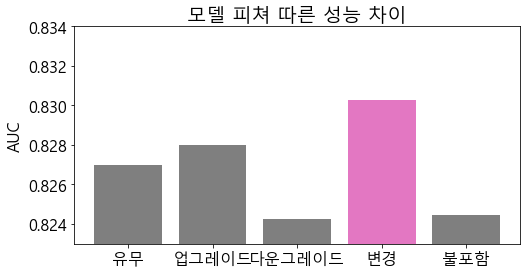

In [35]:
# 1. model 유무 피쳐
feature_model = ['model_'+str(i) for i in range(9)]
result_model = []
con = pd.concat([err_df, model_df[feature_model]], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_model.append(auc_score)

# 2. 모델 업그레이드
con = pd.concat([err_df, model_df['model_upgrade']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_model.append(auc_score)

# 3. 모델 다운그레이드
con = pd.concat([err_df, model_df['model_downgrade']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_model.append(auc_score)

# 4. 모델 변경
con = pd.concat([err_df, model_df['model_diff']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_model.append(auc_score)

# 5. 불포함
_, valid_probs = lgb_train_model(err_df.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_model.append(auc_score)

plt.figure(figsize=(8,4))
plt.bar(range(5), result_model, color='tab:gray')
plt.bar([3], result_model[3], color='tab:pink')
plt.xticks(range(5),['유무', '업그레이드','다운그레이드', '변경','불포함'])
plt.ylabel('AUC')
plt.title('모델 피쳐 따른 성능 차이')
plt.ylim(0.823, 0.834)
plt.show()


* 모델 변경시 모델 성능 면에서 가장 높은 영향력

#### fwver 세분화에 따른 성능 비교 (변경 여부에 따라)

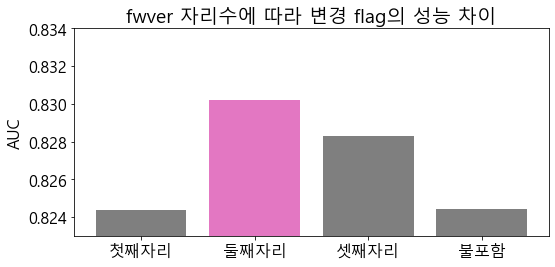

In [36]:
result_fwver_vs = []

# 1. 첫째자리
con = pd.concat([err_df, fwver_df['fwver_diff_0']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_fwver_vs.append(auc_score)

# 2. 둘째자리 (model 변경과 동일)
con = pd.concat([err_df, fwver_df['fwver_diff_1']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_fwver_vs.append(auc_score)

# 3. 셋째자리
con = pd.concat([err_df, fwver_df['fwver_diff_2']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_fwver_vs.append(auc_score)

# 4. 불포함
_, valid_probs = lgb_train_model(err_df.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_fwver_vs.append(auc_score)

plt.figure(figsize=(8,4))
plt.bar(range(4), result_fwver_vs, color='tab:gray')
plt.bar([1], result_fwver_vs[1], color='tab:pink')
plt.xticks(range(4),['첫째자리','둘째자리', '셋째자리','불포함'])
plt.ylabel('AUC')
plt.title('fwver 자리수에 따라 변경 flag의 성능 차이')
plt.ylim(0.823, 0.834)
plt.tight_layout()
plt.show()

* fwver에서 model_nm인 둘째자리 영향이 가장 크게 나타남

### 4-3. Quality 관련
* Quality에서는 -1의 발생, 높은 수치, 그리고 2시간 내 변화가 사용자 불만 접수 원인으로 작용
* 불만 제기 사용자와 그렇지 않은 사용자 간에 확연한 차이가 나타남
* 또한 해당 피쳐를 포함하였을 때 모델 성능이 향상됨을 확인

In [45]:
qual_df = train_qual_df.copy()
qual_df = extract_quality_data(qual_df, 'train')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7727/7727 [01:41<00:00, 76.24it/s]


#### quality의 -1 발생 빈도

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in

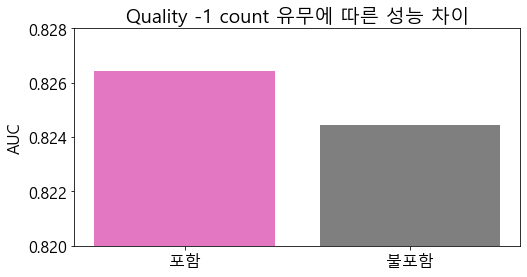

In [38]:
# error_df에 quality_df를 concatenate해서 성능 평가
result_minus = []
minus_1_features = ['quality_'+str(i)+'_minus_1_counts' for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]
train = pd.concat([err_df, qual_df[minus_1_features]], axis=1)
_, valid_probs = lgb_train_model(train, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)

result_minus.append(auc_score)

_, valid_probs = lgb_train_model(err_df, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_minus.append(auc_score)

plt.figure(figsize=(8,4))
plt.bar([0], result_minus[0], color='tab:pink')
plt.bar([1], result_minus[1], color='tab:gray')
plt.xticks(range(2),['포함','불포함'])
plt.ylabel('AUC')
plt.title('Quality -1 count 유무에 따른 성능 차이')
plt.ylim(0.82, 0.828)
plt.show()

#### Quality의 높은 수치

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in

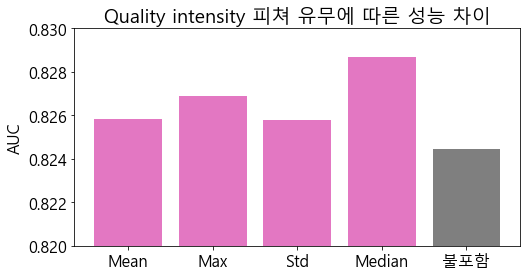

In [39]:
# error_df에 quality_df를 concatenate해서 성능 평가
result_intensity = []
intensity_features_mean = ['quality_'+str(i)+'_mean' for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]
intensity_features_max = ['quality_'+str(i)+'_max' for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]
intensity_features_std = ['quality_'+str(i)+'_std' for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]
intensity_features_med = ['quality_'+str(i)+'_med' for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]
intensity_features = intensity_features_mean + intensity_features_max + intensity_features_std + intensity_features_med


_, valid_probs = lgb_train_model(err_df, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_intensity.append(auc_score)

train = pd.concat([err_df, qual_df[intensity_features_mean]], axis=1)
_, valid_probs = lgb_train_model(train, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)

result_intensity.append(auc_score)

train = pd.concat([err_df, qual_df[intensity_features_max]], axis=1)
_, valid_probs = lgb_train_model(train, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)

result_intensity.append(auc_score)

train = pd.concat([err_df, qual_df[intensity_features_std]], axis=1)
_, valid_probs = lgb_train_model(train, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)

result_intensity.append(auc_score)

train = pd.concat([err_df, qual_df[intensity_features_med]], axis=1)
_, valid_probs = lgb_train_model(train, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)

result_intensity.append(auc_score)

plt.figure(figsize=(8,4))
plt.bar(range(4), result_intensity[1:], color='tab:pink')
plt.bar([4], result_intensity[0], color='tab:gray')
plt.xticks(range(5),['Mean','Max', 'Std','Median', '불포함'])
plt.ylabel('AUC')
plt.title('Quality intensity 피쳐 유무에 따른 성능 차이')
plt.ylim(0.82, 0.83)
plt.show()

#### quality의 평균과 불만 여부의 관계

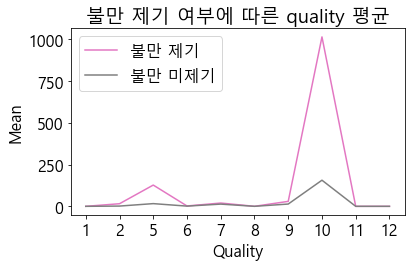

In [47]:
plt.plot(qual_df[intensity_features_mean][problem_user].mean(axis=0), label='불만 제기', color='tab:pink')
plt.plot(qual_df[intensity_features_mean][~problem_user].mean(axis=0), label='불만 미제기', color='tab:gray')
plt.xticks(range(len([1, 2, 5, 6, 7, 8, 9, 10, 11, 12])),[1, 2, 5, 6, 7, 8, 9, 10, 11, 12])
plt.xlabel('Quality')
plt.ylabel('Mean')
plt.title('불만 제기 여부에 따른 quality 평균')
plt.legend()
plt.tight_layout()
plt.show()

#### 불만 제기 여부에 따른 -1의 발생 빈도

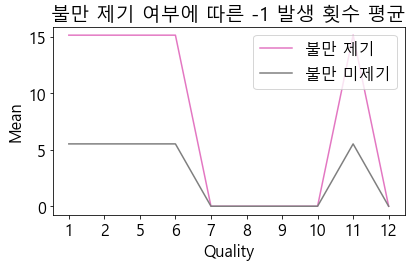

In [48]:
minus_1_features = ['quality_'+str(i)+'_minus_1_counts' for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]
plt.plot(qual_df[minus_1_features][problem_user].mean(axis=0), label='불만 제기', color='tab:pink')
plt.plot(qual_df[minus_1_features][~problem_user].mean(axis=0), label='불만 미제기', color='tab:gray')
plt.xticks(range(len([1, 2, 5, 6, 7, 8, 9, 10, 11, 12])),[1, 2, 5, 6, 7, 8, 9, 10, 11, 12])
plt.xlabel('Quality')
plt.ylabel('Mean')
plt.title('불만 제기 여부에 따른 -1 발생 횟수 평균')
plt.legend()
plt.tight_layout()
plt.show()

#### 12시간 내의 quality 변화 유무

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8281/8281 [03:04<00:00, 44.92it/s]


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines


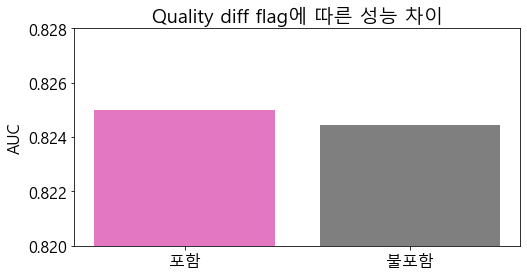

In [42]:
qual_df = train_qual_df.copy()

# 변한 값이 있는지 count
unique_user = np.unique(qual_df['user_id'])
qual_diff_arr = np.zeros((15000, 13), dtype=int)
for user_id in tqdm(unique_user):
    idx = qual_df['user_id'] == user_id
    unique_time = np.unique(qual_df.loc[idx, 'time'])
    for time_ in unique_time:
        time_idx = qual_df.loc[idx, 'time'] == time_
        diff_flag = np.nanstd(qual_df.loc[idx, :].loc[time_idx,'quality_0':'quality_12'].astype(float), axis=0) > 0
        qual_diff_arr[user_id - 10000, :] += diff_flag

# concatenate
result_diff = []
con = pd.concat([err_df, pd.DataFrame(qual_diff_arr)], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_diff.append(auc_score)

# 원본
_, valid_probs = lgb_train_model(err_df, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_diff.append(auc_score)

plt.figure(figsize=(8,4))
plt.bar([0], result_diff[0], color='tab:pink')
plt.bar([1], result_diff[1], color='tab:gray')
plt.xticks(range(2),['포함','불포함'])
plt.ylabel('AUC')
plt.title('Quality diff flag에 따른 성능 차이')
plt.ylim(0.82, 0.828)
plt.show()

#### 불만 제기 여부에 따른 2시간 내 quality 변화 빈도

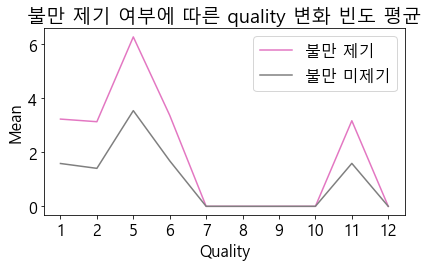

In [49]:
use_idx = np.array([1, 2, 5, 6, 7, 8, 9, 10, 11, 12])
plt.plot(qual_diff_arr[problem_user, :].mean(axis=0)[use_idx], label='불만 제기', color='tab:pink')
plt.plot(qual_diff_arr[~problem_user, :].mean(axis=0)[use_idx], label='불만 미제기', color='tab:gray')

plt.xticks(range(len(use_idx)),use_idx)
plt.xlabel('Quality')
plt.ylabel('Mean')
plt.title('불만 제기 여부에 따른 quality 변화 빈도 평균')
plt.legend()
plt.tight_layout()
plt.show()

## 5. 비즈니스 분석
### 문제발생 이전과 이후 평균 에러 발생량 분석

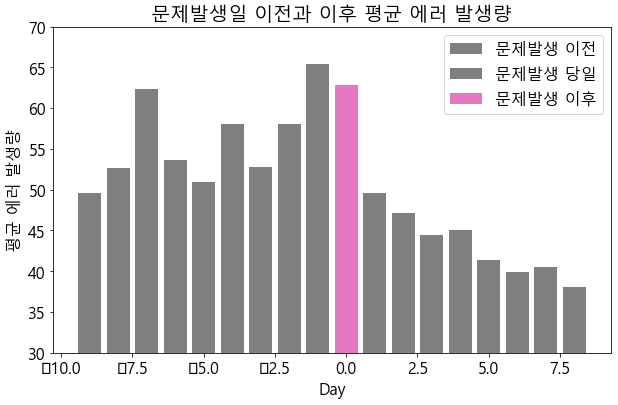

In [50]:
train_err_arr_sum = train_err_arr.sum(axis=2)

data_before = []
data_after = []
for lag in range(0, 10):
    error_counts = []
    for i in range(15000):
        idx = np.where(problem_arr[i,:])[0]
        if idx.sum() == 0:
            continue

        for day in idx:
            if day-lag >=0:
                error_count = train_err_arr_sum[i, day - lag:day - lag+1].sum()
                error_counts.append(error_count)
    error_counts = np.array(error_counts)
    data_before.append(error_counts)


for lag in range(1, 10):
    error_counts = []
    for i in range(15000):
        idx = np.where(problem_arr[i,:])[0]
        if idx.sum() == 0:
            continue
        for day in idx:
            if day+lag <= 30:
                error_count = train_err_arr_sum[i, day+lag-1:day+lag].sum()
                error_counts.append(error_count)
    error_counts = np.array(error_counts)
    data_after.append(error_counts)

before_mean = []
for data in reversed(data_before):
    before_mean.append(np.nanmean(data))
after_mean = []
for data in data_after:
    after_mean.append(np.nanmean(data))

plt.figure(figsize=(10,6))
plt.bar(np.array(range(len(before_mean)))-9, before_mean, color='tab:gray', label='문제발생 이전')
plt.bar(np.array(range(len(before_mean)-1, len(before_mean) + len(after_mean)-1))-9, after_mean, color='tab:gray', label='문제발생 당일')
plt.bar([len(before_mean)-10], before_mean[-1], color='tab:pink', label='문제발생 이후')
plt.ylim([30, 70])
plt.ylabel('평균 에러 발생량')
plt.xlabel('Day')
plt.legend()
plt.title('문제발생일 이전과 이후 평균 에러 발생량')
plt.show()

#### 데이터 분석 기반 고객 사전 관리의 필요성
* 불만 접수 하루 전에 error 발생량이 가장 높음
* 불만 접수 전에 이를 감지할 수 있다면 불만 발생량을 현저히 낮출 수 있을 것이라 기대됨

#### 데이터 분석 기반 고객 사후 관리의 필요성
* 불만 접수 시간에서 발생하는 예상 시나리오 고려
    * 예상 시나리오
        - 불만 접수 시간 전 3일 내: 기기 불량 발생 예상
        - 불만 접수 시간 후 3일 내: 기기 AS 센터 방문 예상
    
* 잔여 5일 (4~8일)은 AS 센터 조치 받은 후 추가적인 기기 고장 등이 발생하는 것으로 간주
* 고객 관리 기간 확대 및 선 조치 필요

## 6. 결론
* Error code를 활용할 시 error type만 사용했을 경우보다 많은 정보를 추출 가능
* Quality 값의 크기와 변화가 error의 발생과 사용자 불만 제기 여부에 연관성을 보임
* 9가지의 사용자 불만 접수 원인을 규명함
* 3일 단위의 에러 합계가 영향력이 큼
* 통계적 특성 분석을 통해 영향력 있는 특징을 추출하고 모델에 반영하여 안정적인 제안 모델을 구축함